In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [3]:
os.chdir('/content/drive/MyDrive/bdanp a1')

In [4]:
# Read all CSV files

# Folder containing all raw CSVs
path = "/content/drive/MyDrive/bdanp a1"

# Read CO files
co_files = glob.glob(os.path.join(path, "CO *.csv"))
df_co = pd.concat([pd.read_csv(f) for f in co_files], ignore_index=True)

# Read NO2 files
no2_files = glob.glob(os.path.join(path, "NO2 *.csv"))
df_no2 = pd.concat([pd.read_csv(f) for f in no2_files], ignore_index=True)

# Read PM2.5 files
pm25_files = glob.glob(os.path.join(path, "PM2.5 *.csv"))
df_pm25 = pd.concat([pd.read_csv(f) for f in pm25_files], ignore_index=True)

print("CO:", df_co.shape)
print("NO2:", df_no2.shape)
print("PM25:", df_pm25.shape)

# Standardize column names
df_co.rename(columns={
    "Daily Max 8-hour CO Concentration": "CO_ppm",
    "Date": "Date"
}, inplace=True)

df_no2.rename(columns={
    "Daily Max 1-hour NO2 Concentration": "NO2_ppb",
    "Date": "Date"
}, inplace=True)

df_pm25.rename(columns={
    "Daily Mean PM2.5 Concentration": "PM25_ugm3",
    "Date": "Date"
}, inplace=True)

# Parse dates
df_co['Date'] = pd.to_datetime(df_co['Date'])
df_no2['Date'] = pd.to_datetime(df_no2['Date'])
df_pm25['Date'] = pd.to_datetime(df_pm25['Date'])

# Build a daily panel

# Keep needed columns
co_keep = df_co[['Date', 'CO_ppm']]
no2_keep = df_no2[['Date', 'NO2_ppb']]
pm25_keep = df_pm25[['Date', 'PM25_ugm3']]

# Outer-join by Date
df_merge = co_keep.merge(no2_keep, on='Date', how='outer')
df_merge = df_merge.merge(pm25_keep, on='Date', how='outer')

# Sort by date
df_merge = df_merge.sort_values('Date')

print(df_merge.head())

# Aggregate to monthly panel
df_merge['YearMonth'] = df_merge['Date'].dt.to_period('M')
df_monthly = (
    df_merge
    .groupby('YearMonth')[['CO_ppm', 'NO2_ppb', 'PM25_ugm3']]
    .mean()
    .reset_index()
)
df_monthly['YearMonth'] = df_monthly['YearMonth'].astype(str)

print(df_monthly.head())

# Save outputs
df_merge.to_csv("AirQuality_DailyPanel.csv", index=False)
df_monthly.to_csv("AirQuality_MonthlyPanel.csv", index=False)


CO: (2370, 21)
NO2: (2739, 21)
PM25: (2780, 22)
        Date  CO_ppm  NO2_ppb  PM25_ugm3
0 2017-01-01     0.4     17.8        5.7
1 2017-01-02     0.5     32.7        4.2
2 2017-01-03     0.4     26.4        3.6
3 2017-01-04     0.6     37.4        4.9
4 2017-01-05     1.1     51.0       12.2
  YearMonth    CO_ppm    NO2_ppb  PM25_ugm3
0   2017-01  0.761290  36.025926   8.412903
1   2017-02  0.540000  36.950000   5.325000
2   2017-03  0.541935  37.612903   4.261290
3   2017-04  0.503448  35.862069   5.300000
4   2017-05  0.554839  37.236000   6.548387


 EV Monthly Aggregated Sample:
  YearMonth  Electric Vehicle (EV) Total  Percent Electric Vehicles
0   2017-01                      12421.0                       0.89
1   2017-02                      12806.0                       0.92
2   2017-03                      13099.0                       0.94
3   2017-04                      13435.0                       0.97
4   2017-05                      13781.0                       0.99
Air Quality Monthly Panel Sample:
  YearMonth    CO_ppm    NO2_ppb  PM25_ugm3
0   2017-01  0.761290  36.025926   8.412903
1   2017-02  0.540000  36.950000   5.325000
2   2017-03  0.541935  37.612903   4.261290
3   2017-04  0.503448  35.862069   5.300000
4   2017-05  0.554839  37.236000   6.548387
Merged Data Sample:
  YearMonth    CO_ppm    NO2_ppb  PM25_ugm3  Electric Vehicle (EV) Total  \
0   2017-01  0.761290  36.025926   8.412903                      12421.0   
1   2017-02  0.540000  36.950000   5.325000                      12806.0   
2   2017-03  0.

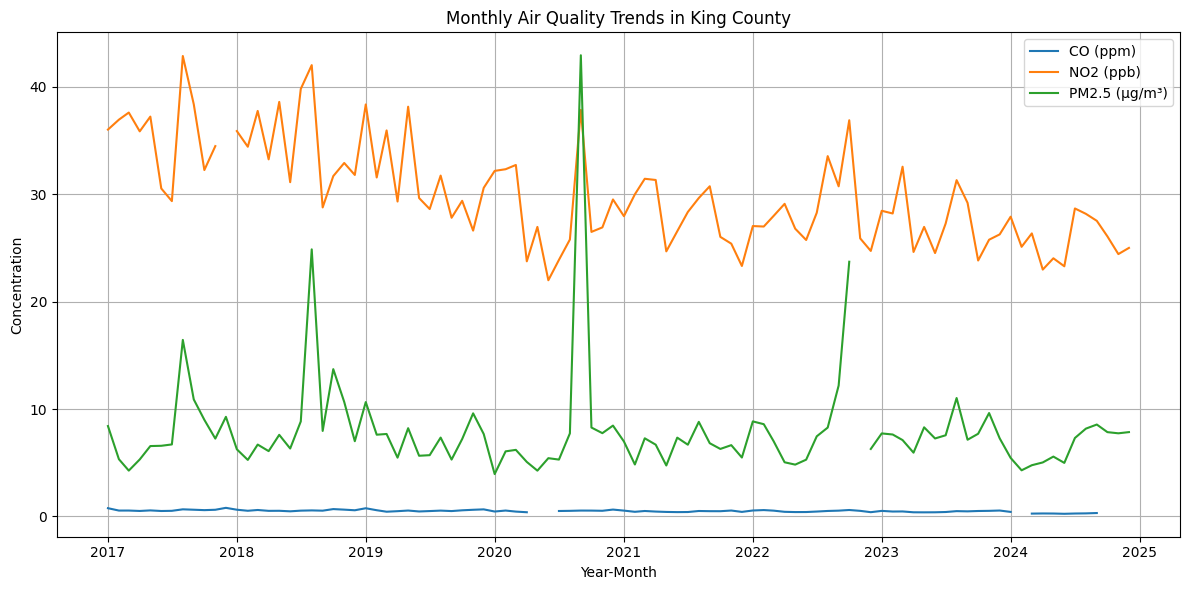

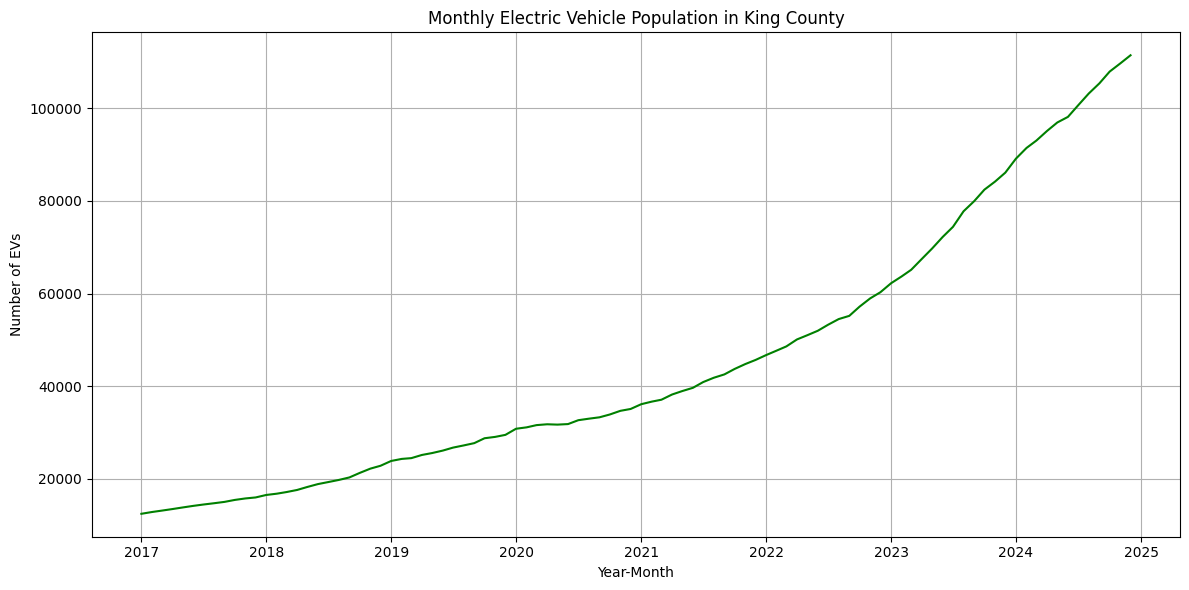

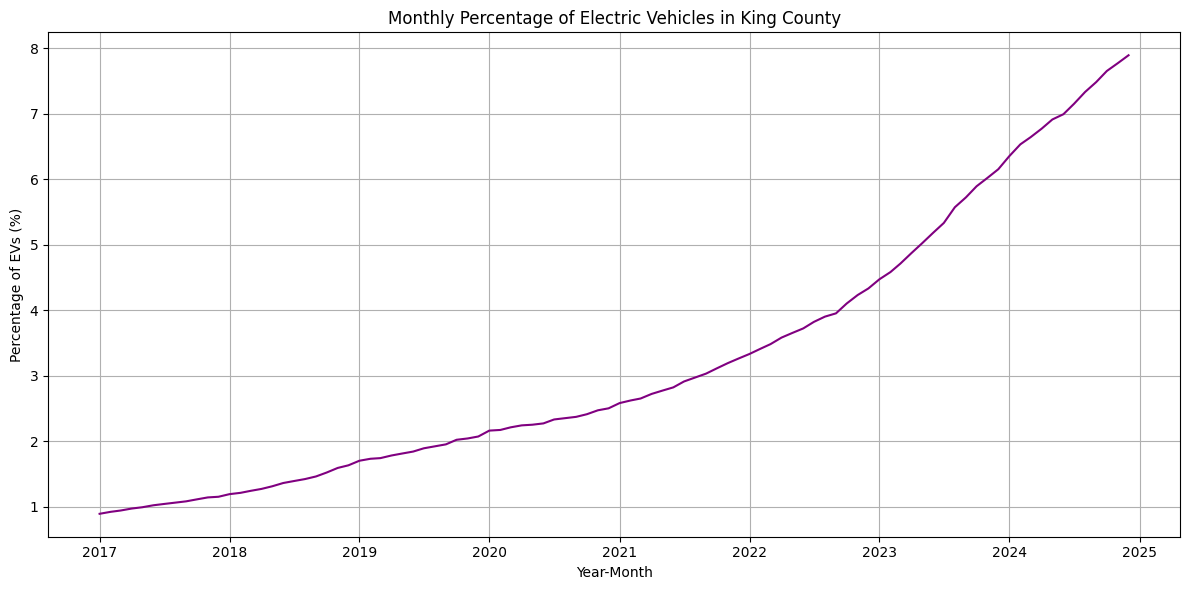

In [7]:
# Load Electric Vehicle Population Data
ev = pd.read_csv("Electric_Vehicle_Population_Size_History_By_County.csv")

# Filter for King County and Passenger vehicles only
ev = ev[
    (ev['County'].str.lower() == 'king') &
    (ev['Vehicle Primary Use'].str.lower() == 'passenger')
]

# Convert 'Date' to datetime and extract YearMonth
ev['Date'] = pd.to_datetime(ev['Date'], errors='coerce')
ev['YearMonth'] = ev['Date'].dt.to_period('M').astype(str)

# Aggregate by YearMonth: calculate monthly average EV count and EV percentage
ev_monthly = ev.groupby('YearMonth').agg({
    'Electric Vehicle (EV) Total': 'mean',
    'Percent Electric Vehicles': 'mean'
}).reset_index()

print(" EV Monthly Aggregated Sample:")
print(ev_monthly.head())

# Load Air Quality Monthly Panel
aq = pd.read_csv("AirQuality_MonthlyPanel.csv")

print("Air Quality Monthly Panel Sample:")
print(aq.head())

# Merge EV and Air Quality Data by YearMonth
final = aq.merge(ev_monthly, on='YearMonth', how='inner')

print("Merged Data Sample:")
print(final.head())

# Save final merged dataset
final.to_csv("Final_Monthly_Dataset.csv", index=False)
print("Final_Monthly_Dataset.csv has been saved successfully!")

# Visualize Trends

# Set YearMonth as datetime index for plotting
final_plot = final.copy()
final_plot['YearMonth'] = pd.to_datetime(final_plot['YearMonth'])

# Plot Air Quality Metrics over Time
plt.figure(figsize=(12, 6))
plt.plot(final_plot['YearMonth'], final_plot['CO_ppm'], label='CO (ppm)')
plt.plot(final_plot['YearMonth'], final_plot['NO2_ppb'], label='NO2 (ppb)')
plt.plot(final_plot['YearMonth'], final_plot['PM25_ugm3'], label='PM2.5 (µg/m³)')
plt.title("Monthly Air Quality Trends in King County")
plt.xlabel("Year-Month")
plt.ylabel("Concentration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Electric Vehicle Population over Time
plt.figure(figsize=(12, 6))
plt.plot(final_plot['YearMonth'], final_plot['Electric Vehicle (EV) Total'], color='green')
plt.title("Monthly Electric Vehicle Population in King County")
plt.xlabel("Year-Month")
plt.ylabel("Number of EVs")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot EV Percentage over Time
plt.figure(figsize=(12, 6))
plt.plot(final_plot['YearMonth'], final_plot['Percent Electric Vehicles'], color='purple')
plt.title("Monthly Percentage of Electric Vehicles in King County")
plt.xlabel("Year-Month")
plt.ylabel("Percentage of EVs (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# Load weather files
w1 = pd.read_csv("weather_2017-2020.csv")
w2 = pd.read_csv("weather_2021-2024.csv")

# Combine
weather = pd.concat([w1, w2], ignore_index=True)

# Convert DATE to datetime and extract YearMonth
weather['DATE'] = pd.to_datetime(weather['DATE'])
weather['YearMonth'] = weather['DATE'].dt.to_period('M').astype(str)

# Aggregate to monthly
weather_monthly = weather.groupby('YearMonth').agg({
    'AWND': 'mean',
    'PRCP': 'sum',
    'TAVG': 'mean',
    'TMAX': 'mean',
    'TMIN': 'mean'
}).reset_index()

print("Weather monthly sample:")
print(weather_monthly.head())

# Load EIA generation & calculate shares
eia = pd.read_csv("Net_generation_for_electric_power.csv")

# Keep only Washington : fuel rows, remove 'all fuels'
eia_wa = eia[eia['description'].str.contains('Washington :')]
eia_wa = eia_wa[~eia_wa['description'].str.contains('all fuels', case=False)]

# Melt to long
eia_long = eia_wa.melt(
    id_vars=['description'],
    value_vars=[str(y) for y in range(2017, 2025)],
    var_name='Year',
    value_name='Generation'
)
eia_long['Fuel_Type'] = eia_long['description'].str.replace('Washington : ', '').str.strip()
eia_long['Generation'] = pd.to_numeric(eia_long['Generation'], errors='coerce')

# Pivot to wide
eia_pivot = eia_long.pivot_table(index='Year', columns='Fuel_Type', values='Generation').reset_index()

# Calculate Total and Shares
eia_pivot['Total'] = eia_pivot.drop(columns=['Year']).sum(axis=1, numeric_only=True)
# Print column names to verify the actual field names
print("EIA Pivot columns:", eia_pivot.columns.tolist())

# Define the exact fuel column names you see in your printed output

# Calculate Renewable_Share
renewable_fuels = ['conventional hydroelectric', 'all utility-scale solar', 'wind']

# Ensure columns exist
for col in renewable_fuels + ['coal']:
    if col not in eia_pivot.columns:
        print(f"Warning: {col} not found!")

# Correct calculation
eia_pivot['Renewable_Share'] = eia_pivot[renewable_fuels].sum(axis=1) / eia_pivot['Total']

# Correct Coal Share
eia_pivot['Coal_Share'] = eia_pivot['coal'] / eia_pivot['Total']

print("Corrected Renewable_Share & Coal_Share:")
print(eia_pivot[['Year', 'Renewable_Share', 'Coal_Share']])

print("EIA shares sample:")
print(eia_pivot.head())

# Merge with Final_Monthly_Dataset
final = pd.read_csv("Final_Monthly_Dataset.csv")

# Extract Year and ensure integer type
final['Year'] = pd.to_datetime(final['YearMonth']).dt.year
final['Year'] = pd.to_numeric(final['Year'], errors='coerce').astype('Int64')
eia_pivot['Year'] = pd.to_numeric(eia_pivot['Year'], errors='coerce').astype('Int64')

# Merge EIA shares
final = final.merge(eia_pivot[['Year', 'Renewable_Share', 'Coal_Share']], on='Year', how='left')

# Merge weather monthly
final = final.merge(weather_monthly, on='YearMonth', how='left')

# Save final file
final.to_csv("Final_Monthly_Dataset_With_Weather_EIA.csv", index=False)

print("Final_Monthly_Dataset_With_Weather_EIA.csv has been saved!")


Weather monthly sample:
  YearMonth      AWND    PRCP       TAVG       TMAX       TMIN
0   2017-01  3.589032  237.92  28.365591  36.817378  26.201767
1   2017-02  4.218000  589.50  31.516418  39.690671  30.124386
2   2017-03  5.035032  604.69  35.930108  44.608567  34.397341
3   2017-04  4.772133  347.18  39.061111  49.996947  37.138931
4   2017-05  3.874645  230.76  47.927419  61.648449  42.723781
EIA Pivot columns: ['Year', 'all utility-scale solar', 'biomass', 'coal', 'conventional hydroelectric', 'hydro-electric pumped storage', 'natural gas', 'nuclear', 'other', 'other biomass', 'petroleum liquids', 'wind', 'wood and wood-derived fuels', 'Total']
Corrected Renewable_Share & Coal_Share:
Fuel_Type  Year  Renewable_Share  Coal_Share
0          2017         0.776892    0.047629
1          2018         0.768868    0.046408
2          2019         0.695109    0.068289
3          2020         0.749534    0.044969
4          2021         0.740533    0.028501
5          2022         0.7566

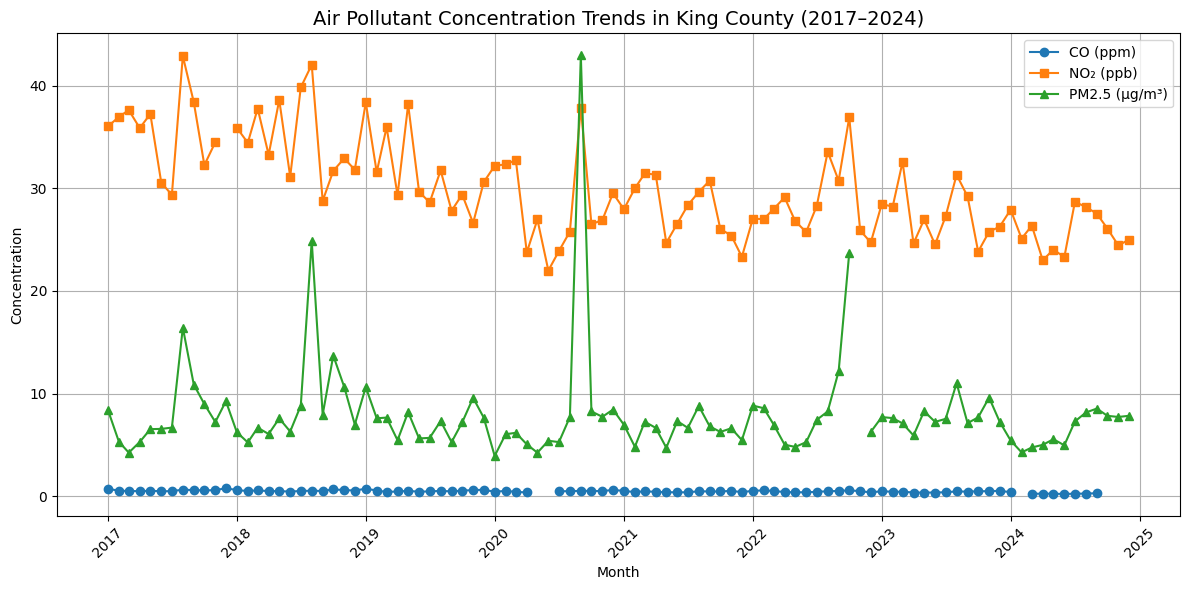

In [9]:
# load
df = pd.read_csv("Final_Monthly_Dataset_With_Weather_EIA.csv")
df['YearMonth'] = pd.to_datetime(df['YearMonth'].astype(str))

# plot
plt.figure(figsize=(12, 6))
plt.plot(df['YearMonth'], df['CO_ppm'], label='CO (ppm)', marker='o')
plt.plot(df['YearMonth'], df['NO2_ppb'], label='NO₂ (ppb)', marker='s')
plt.plot(df['YearMonth'], df['PM25_ugm3'], label='PM2.5 (µg/m³)', marker='^')
plt.title("Air Pollutant Concentration Trends in King County (2017–2024)", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Concentration")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


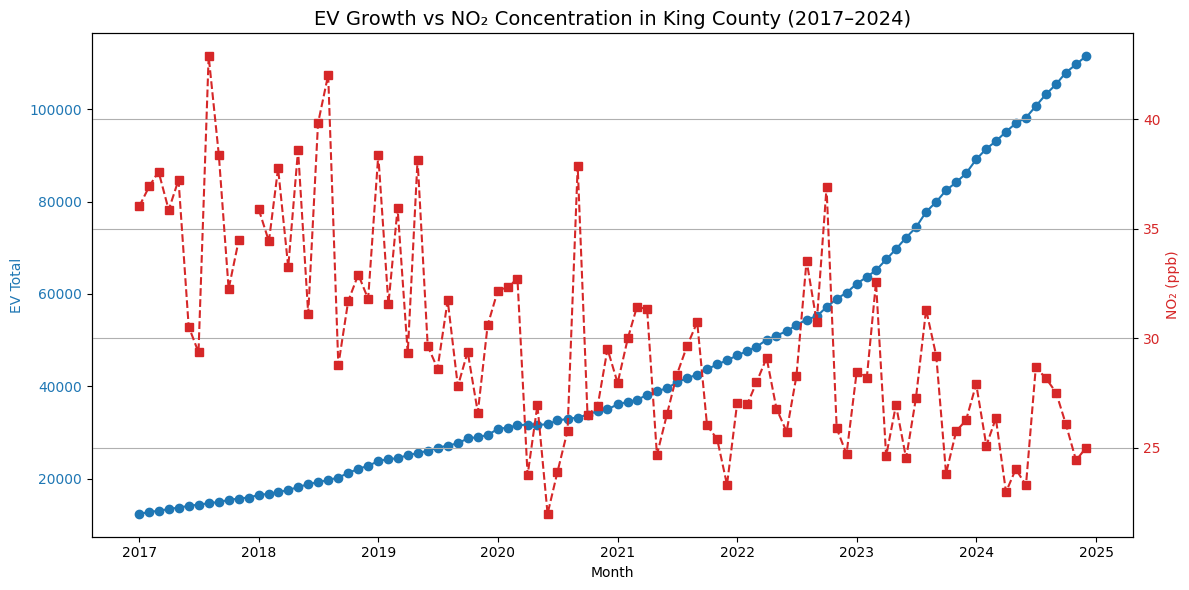

In [10]:
# Create a dual-axis plot: EV total (left axis) vs. NO₂ concentration
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left axis: plot EV total
color = 'tab:blue'
ax1.set_xlabel('Month')
ax1.set_ylabel('EV Total', color=color)
ax1.plot(df['YearMonth'], df['Electric Vehicle (EV) Total'], color=color, label='EV Total', marker='o')
ax1.tick_params(axis='y', labelcolor=color)

# Right axis: plot NO₂ concentration
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('NO₂ (ppb)', color=color)
ax2.plot(df['YearMonth'], df['NO2_ppb'], color=color, label='NO₂ (ppb)', linestyle='--', marker='s')
ax2.tick_params(axis='y', labelcolor=color)

# Title, layout, and styling
plt.title('EV Growth vs NO₂ Concentration in King County (2017–2024)', fontsize=14)
fig.tight_layout()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



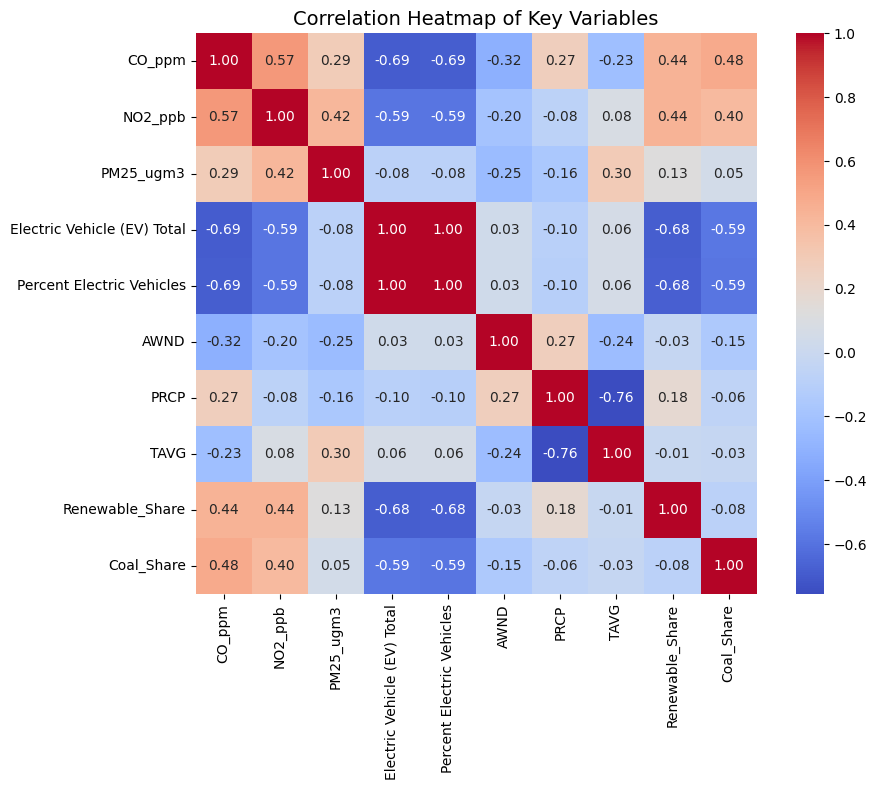

In [11]:
# Select variables for the heatmap analysis
corr_df = df[[
    'CO_ppm', 'NO2_ppb', 'PM25_ugm3',
    'Electric Vehicle (EV) Total', 'Percent Electric Vehicles',
    'AWND', 'PRCP', 'TAVG', 'Renewable_Share', 'Coal_Share'
]]

# Compute the Pearson correlation matrix
corr_matrix = corr_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap of Key Variables", fontsize=14)
plt.tight_layout()
plt.show()


In [12]:
# Prepare regression data: drop rows with missing values
reg_df = df[['NO2_ppb', 'Electric Vehicle (EV) Total', 'AWND', 'PRCP', 'TAVG', 'Renewable_Share', 'Coal_Share']].dropna()

# Define predictors (X) and target (y)
X = reg_df.drop(columns=['NO2_ppb'])
y = reg_df['NO2_ppb']

# Add an intercept term
X = sm.add_constant(X)

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Display the regression summary
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                NO2_ppb   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     10.40
Date:                Sun, 17 Aug 2025   Prob (F-statistic):           1.09e-08
Time:                        13:47:57   Log-Likelihood:                -256.86
No. Observations:                  95   AIC:                             527.7
Df Residuals:                      88   BIC:                             545.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                         -10.1229     25.184     -0.402      0.689     -60.171      39.925
Electric Vehicle (EV) Total -2.103e-05    4.2e-05     -0.501      0.618      -0.000    6.24e-05
AWND                           -0.5915      0.483     -1.225      0.224      -1.551       0.368
PRCP                           -0.0029      0.003     -0.924      0.358      -0.009       0.003
TAVG                           -0.0108      0.059     -0.183      0.855      -0.129       0.107
Renewable_Share                55.2073     28.044      1.969      0.052      -0.524     110.939
Coal_Share                    128.2900     69.058      1.858      0.067      -8.949     265.529
==============================================================================
Omnibus:                        0.064   Durbin-Watson:                   1.548
Prob(Omnibus):                  0.968   Jarque-Bera (JB):                0.195
Skew:                          -0.050   Prob(JB):                        0.907
Kurtosis:                       2.802   Cond. No.                     1.06e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/bdanp a1/Final_Monthly_Dataset_With_Weather_EIA.csv")

# Convert YearMonth to datetime
df['YearMonth'] = pd.to_datetime(df['YearMonth'])
df = df.sort_values('YearMonth').reset_index(drop=True)

# Impute Missing Values (Linear)
# Interpolate pollution variables by time
df[['CO_ppm', 'NO2_ppb', 'PM25_ugm3']] = df[['CO_ppm', 'NO2_ppb', 'PM25_ugm3']].interpolate(method='linear')

# check still missing
print("Remaining missing values:\n", df.isnull().sum())

# Feature Selection
# Drop redundant or uninformative columns
drop_cols = ['Percent Electric Vehicles', 'TMAX', 'TMIN']
df = df.drop(columns=[col for col in drop_cols if col in df.columns])

# Rename for convenience
df = df.rename(columns={
    'Electric Vehicle (EV) Total': 'EV_Total'
})

# Scaling (Standardization)
# Define feature columns (X) and target (y)
feature_cols = ['EV_Total', 'AWND', 'PRCP', 'TAVG', 'Renewable_Share', 'Coal_Share']
target_col = 'NO2_ppb'

# Keep non-feature columns for merging later
meta_cols = ['YearMonth']

# Scale features
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[feature_cols] = scaler.fit_transform(df[feature_cols])

# Save Clean Dataset
# Save scaled version for modelling
df_scaled.to_csv("Cleaned_Monthly_Dataset_Scaled.csv", index=False)

# save unscaled version with imputed values
df.to_csv("Cleaned_Monthly_Dataset_Unscaled.csv", index=False)

print("Data preprocessing complete. Clean files saved.")


Remaining missing values:
 YearMonth                      0
CO_ppm                         0
NO2_ppb                        0
PM25_ugm3                      0
Electric Vehicle (EV) Total    0
Percent Electric Vehicles      0
Year                           0
Renewable_Share                0
Coal_Share                     0
AWND                           0
PRCP                           0
TAVG                           0
TMAX                           0
TMIN                           0
dtype: int64
Data preprocessing complete. Clean files saved.


In [ ]:
# Read VMT.xlsx
vmt_df = pd.read_excel('/content/drive/MyDrive/bdanp a1/VMT.xlsx')

# Normalize column names (trim spaces)
vmt_df.columns = vmt_df.columns.str.strip()

# Convert 'Date' from mm/yyyy to yyyy-mm
vmt_df['Date'] = pd.to_datetime(vmt_df['Date'], format='%m/%Y', errors='coerce')
vmt_df['YearMonth'] = vmt_df['Date'].dt.strftime('%Y-%m')

# Rename the VMT column to a consistent name (change if your column differs)
vmt_df = vmt_df.rename(columns={'Vehicle-miles M(Millions)': 'VMT'})

# Save to CSV
vmt_df[['YearMonth', 'VMT']].to_csv('/content/drive/MyDrive/bdanp a1/VMT.csv', index=False)

# Read the main monthly dataset
main_df = pd.read_csv('/content/drive/MyDrive/bdanp a1/Final_Monthly_Dataset_With_Weather_EIA.csv')
main_df.columns = main_df.columns.str.strip()
main_df['YearMonth'] = main_df['YearMonth'].astype(str).str.strip()

# Merge the two datasets on YearMonth
merged_df = pd.merge(main_df, vmt_df[['YearMonth', 'VMT']], on='YearMonth', how='left')

# Save the merged result
merged_df.to_csv('/content/drive/MyDrive/bdanp a1/Final_Monthly_Dataset_With_VMT.csv', index=False)

# Quick check
print(merged_df[['YearMonth', 'VMT']].head())


In [ ]:
# Load Dataset
df = pd.read_csv('/content/drive/MyDrive/bdanp a1/Final_Monthly_Dataset_With_VMT.csv')
df = df.dropna(subset=['NO2_ppb', 'VMT'])
df = df.fillna(df.median(numeric_only=True))

# Define features & target
X = df.drop(columns=['NO2_ppb', 'YearMonth'])
y = df['NO2_ppb']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model List
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR(),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0)
}

# Train and Evaluate
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2  = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    results.append({'Model': name, 'R2': r2, 'MSE': mse})

results_df = pd.DataFrame(results)

# R² Bar Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Model', y='R2')
plt.title("Model Comparison: R²")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Find the model name with the highest R²
best_model_name = results_df.loc[results_df['R2'].idxmax(), 'Model']
best_model = models[best_model_name]

# Fit and predict with the best model
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Plot Actual vs. Predicted with a 1:1 reference line
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual NO₂")
plt.ylabel("Predicted NO₂")
plt.title(f"{best_model_name}: Actual vs Predicted NO₂")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.tight_layout()
plt.show()


# Custom MAPE function to avoid division-by-zero
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = pd.Series(y_true), pd.Series(y_pred)
    epsilon = 1e-10
    ape = np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), epsilon)) * 100
    return ape.mean()



# Train and Evaluate
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2   = r2_score(y_test, y_pred)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    mae  = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    results.append({
        'Model': name,
        'R2': r2,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE(%)': mape
    })

results_df = pd.DataFrame(results)
display(results_df)



In [ ]:
# Load Dataset
df = pd.read_csv('/content/drive/MyDrive/bdanp a1/Final_Monthly_Dataset_With_VMT.csv')
df = df.dropna(subset=['NO2_ppb', 'VMT'])
df = df.fillna(df.median(numeric_only=True))

# Define Features & Target
X = df.drop(columns=['NO2_ppb', 'YearMonth'])
y = df['NO2_ppb']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models (some with GridSearchCV)
models = {
    "Linear Regression": LinearRegression(),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR()
}

# Random Forest with GridSearch
rf_params = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=3, scoring='r2', n_jobs=-1)
rf_grid.fit(X_train, y_train)
models["Random Forest"] = rf_grid.best_estimator_

# Print best parameters
print("Best Parameters for Random Forest:", rf_grid.best_params_)

# XGBoost with GridSearch
xgb_params = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.05, 0.1],
}
xgb_grid = GridSearchCV(XGBRegressor(random_state=42, verbosity=0), xgb_params, cv=3, scoring='r2', n_jobs=-1)
xgb_grid.fit(X_train, y_train)
models["XGBoost"] = xgb_grid.best_estimator_

# Print best parameters
print("Best Parameters for XGBoost:", xgb_grid.best_params_)


# Train & Evaluate
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    results.append({
        "Model": name,
        "R2": r2,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE(%)": mape
    })

results_df = pd.DataFrame(results).sort_values(by='R2', ascending=False)

# R² Bar Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Model', y='R2')
plt.title("Model Comparison: R²")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Best Model
best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]

# Prediction Plot
y_pred = best_model.predict(X_test)
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual NO₂")
plt.ylabel("Predicted NO₂")
plt.title(f"{best_model_name}: Actual vs Predicted NO₂")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.tight_layout()
plt.show()

# Display Result Table
display(results_df)


In [ ]:
# Prepare features and target
features_all = df.drop(columns=['NO2_ppb', 'YearMonth'])
features_no_vmt = features_all.drop(columns=['VMT'])
target = df['NO2_ppb']

# Define models and parameters
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, max_depth=3, learning_rate=0.1, random_state=42, verbosity=0),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR(),
}

# Container for results
results = []

for name, model in models.items():
    # With VMT (random 80/20 split for comparability)
    X_train1, X_test1, y_train1, y_test1 = train_test_split(features_all, target, test_size=0.2, random_state=42)
    model.fit(X_train1, y_train1)
    r2_with_vmt = r2_score(y_test1, model.predict(X_test1))

    # Without VMT
    X_train2, X_test2, y_train2, y_test2 = train_test_split(features_no_vmt, target, test_size=0.2, random_state=42)
    model.fit(X_train2, y_train2)
    r2_without_vmt = r2_score(y_test2, model.predict(X_test2))

    results.append({
        "Model": name,
        "R² with VMT": round(r2_with_vmt, 3),
        "R² without VMT": round(r2_without_vmt, 3),
        "Difference": round(r2_with_vmt - r2_without_vmt, 3),
    })

# Show results
results_df = pd.DataFrame(results)
print(results_df)


In [ ]:
# Model
model = xgb.XGBRegressor().fit(X, y)

# Get importance
importances = model.feature_importances_
feat_names = X.columns

# Plot
plt.figure(figsize=(8, 5))
plt.barh(feat_names, importances)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()